In [14]:
import sys
import datetime
import matplotlib.pyplot as plt
from pathlib import Path
import pyarrow as pa
import pyarrow.parquet as pq
import os
import pandas as pd
import logging
sys.path.append(r'C:\Users\Administrator\finstral-1')
import qt_api.qt_api as qt
import src.local_symbols as local_symbols
import src.local_candles as local_candles


In [2]:
# Read the list of symbols from the DOWJONES CSV file
symbols_file = "../lists/DOWJONES.csv"
list_name = os.path.basename(symbols_file).split('.')[0]
symbols_list = pd.read_csv(symbols_file, sep=";")

In [3]:
df = local_candles.load_parquet()
df

[WindowsPath('C:/Users/Administrator/finstral-1/data/parquet/20250406_AG_combined.parquet')]
📂 Loading most recent parquet file: 20250406_AG_combined.parquet


interval                  end    open    high  \
item_id timestamp                                                             
BRK.B   2025-01-06 06:15:00  OneMinute  2025-01-06 06:16:00  456.10  456.20   
        2025-01-06 06:21:00  OneMinute  2025-01-06 06:22:00  456.35  456.35   
        2025-01-06 07:00:00  OneMinute  2025-01-06 07:01:00  456.54  456.54   
        2025-01-06 07:59:00  OneMinute  2025-01-06 08:00:00  456.30  456.30   
        2025-01-06 08:00:00  OneMinute  2025-01-06 08:01:00  456.71  456.71   
...                                ...                  ...     ...     ...   
MDB     2025-04-04 18:54:00  OneMinute  2025-04-04 18:55:00  153.95  153.95   
        2025-04-04 19:00:00  OneMinute  2025-04-04 19:01:00  153.51  153.51   
        2025-04-04 19:36:00  OneMinute  2025-04-04 19:37:00  153.51  153.51   
        2025-04-04 19:50:00  OneMinute  2025-04-04 19:51:00  153.50  153.50   
        2025-04-04 19:59:00  OneMinute  2025-04-04 20:00:00  153.50  153.50   

                                low   close  volume        VWAP  \
item_id timestamp                                                 
BRK.B   2025-01-06 06:15:00  456.10  456.20     258  455.882852   
        2025-01-06 06:21:00  456.35  456.35     100  455.961142   
        2025-01-06 07:00:00  456.07  456.07     300  456.179291   
        2025-01-06 07:59:00  456.30  456.30     346  456.208096   
        2025-01-06 08:00:00  456.31  456.31    1484  456.240498   
...                             ...     ...     ...         ...   
MDB     2025-04-04 18:54:00  153.95  153.95     496  156.060306   
        2025-04-04 19:00:00  153.51  153.51     110  156.060191   
        2025-04-04 19:36:00  153.51  153.51     398  156.060250   
        2025-04-04 19:50:00  153.50  153.50     110  156.060318   
        2025-04-04 19:59:00  153.50  153.50     693  156.059773   

                                industrySector  
item_id timestamp                               
BRK.B   2025-01-06 06:15:00  FinancialServices  
        2025-01-06 06:21:00  FinancialServices  
        2025-01-06 07:00:00  FinancialServices  
        2025-01-06 07:59:00  FinancialServices  
        2025-01-06 08:00:00  FinancialServices  
...                                        ...  
MDB     2025-04-04 18:54:00         Technology  
        2025-04-04 19:00:00         Technology  
        2025-04-04 19:36:00         Technology  
        2025-04-04 19:50:00         Technology  
        2025-04-04 19:59:00         Technology  

[15765758 rows x 9 columns]

In [4]:
symbols_list['Symbol']# First, get the list of symbols we want to keep
valid_symbols = symbols_list['Symbol'].tolist()

# Filter the DataFrame to keep only rows where item_id is in valid_symbols
df_filtered = df[df.index.get_level_values('item_id').isin(valid_symbols)]
print(f"List name: {list_name}")
print(f"Original rows: {len(df)}")
print(f"Filtered rows: {len(df_filtered)}")
print(f"\nSymbols kept: {len(df_filtered.index.get_level_values('item_id').unique())}")

List name: DOWJONES
Original rows: 15765758
Filtered rows: 885632

Symbols kept: 30


In [5]:
# Create target column for prediction
# Make a copy of the filtered dataframe to avoid SettingWithCopyWarning
df_filtered = df_filtered.copy()
# Now safely add the target column
df_filtered['target'] = df_filtered['close'].astype(float)


In [6]:
import pandas as pd
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [7]:
predictor = TimeSeriesPredictor(
    prediction_length=48,
    path=f"../models/autogluon-close-minute-{list_name}",
    target="target",
    eval_metric="RMSE",
    freq="1min",
    verbosity=2,
    #known_covariates_names=['industrySector', 'open', 'high', 'low', 'close', 'volume', 'VWAP']
)



# Optimized fit configuration
predictor.fit(
    train_data=df_filtered,  # Use df_filtered which has the target column instead of df
    presets="fast_training",
    time_limit=1200,
    #hyperparameters=hyperparameters,
    num_val_windows=3,
    refit_full=True,
    enable_ensemble=True,
    random_seed=123
)

Frequency '1min' stored as 'min'
Beginning AutoGluon training... Time limit = 1200s
AutoGluon will save models to 'c:\Users\Administrator\finstral-1\models\autogluon-close-minute-DOWJONES'
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.11.9
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.17763
CPU Count:          40
GPU Count:          1
Memory Avail:       331.65 GB / 383.91 GB (86.4%)
Disk Space Avail:   566.26 GB / 1787.27 GB (31.7%)
Setting presets to: fast_training

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': RMSE,
 'freq': 'min',
 'hyperparameters': 'very_light',
 'known_covariates_names': [],
 'num_val_windows': 3,
 'prediction_length': 48,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': True,
 'skip_model_selection': False,
 'target': 'target',
 'time_limit': 1200,
 'verbosity': 2}

train_data

In [10]:
# We need to use df_filtered which has the target column, not df
# Also, we need to make sure we're predicting on data that has the same structure as training data
predictions = predictor.predict(df_filtered)
predictions.head()

data with frequency 'None' has been resampled to frequency 'min'.
Model not specified in predict, will default to the model with the best validation score: Theta_FULL


mean         0.1         0.2         0.3  \
item_id timestamp                                                             
GS      2025-04-04 19:50:00  467.359955  466.499371  466.754272  466.942084   
        2025-04-04 19:51:00  467.344391  466.092526  466.475330  466.763055   
        2025-04-04 19:52:00  467.328827  465.690744  466.196448  466.527625   
        2025-04-04 19:53:00  467.313263  465.617038  466.065234  466.446201   
        2025-04-04 19:54:00  467.297699  465.448993  465.925470  466.374808   

                                    0.4         0.5         0.6         0.7  \
item_id timestamp                                                             
GS      2025-04-04 19:50:00  467.195148  467.397964  467.615656  467.809491   
        2025-04-04 19:51:00  467.059900  467.281372  467.481653  467.789697   
        2025-04-04 19:52:00  466.914276  467.215393  467.576941  467.864713   
        2025-04-04 19:53:00  466.702026  466.941284  467.380646  467.786383   
        2025-04-04 19:54:00  466.724182  467.063202  467.528320  467.933926   

                                    0.8         0.9  
item_id timestamp                                    
GS      2025-04-04 19:50:00  468.024963  468.404706  
        2025-04-04 19:51:00  468.110046  468.589670  
        2025-04-04 19:52:00  468.258630  468.869000  
        2025-04-04 19:53:00  468.231433  468.644949  
        2025-04-04 19:54:00  468.330975  469.158374

data with frequency 'None' has been resampled to frequency 'min'.


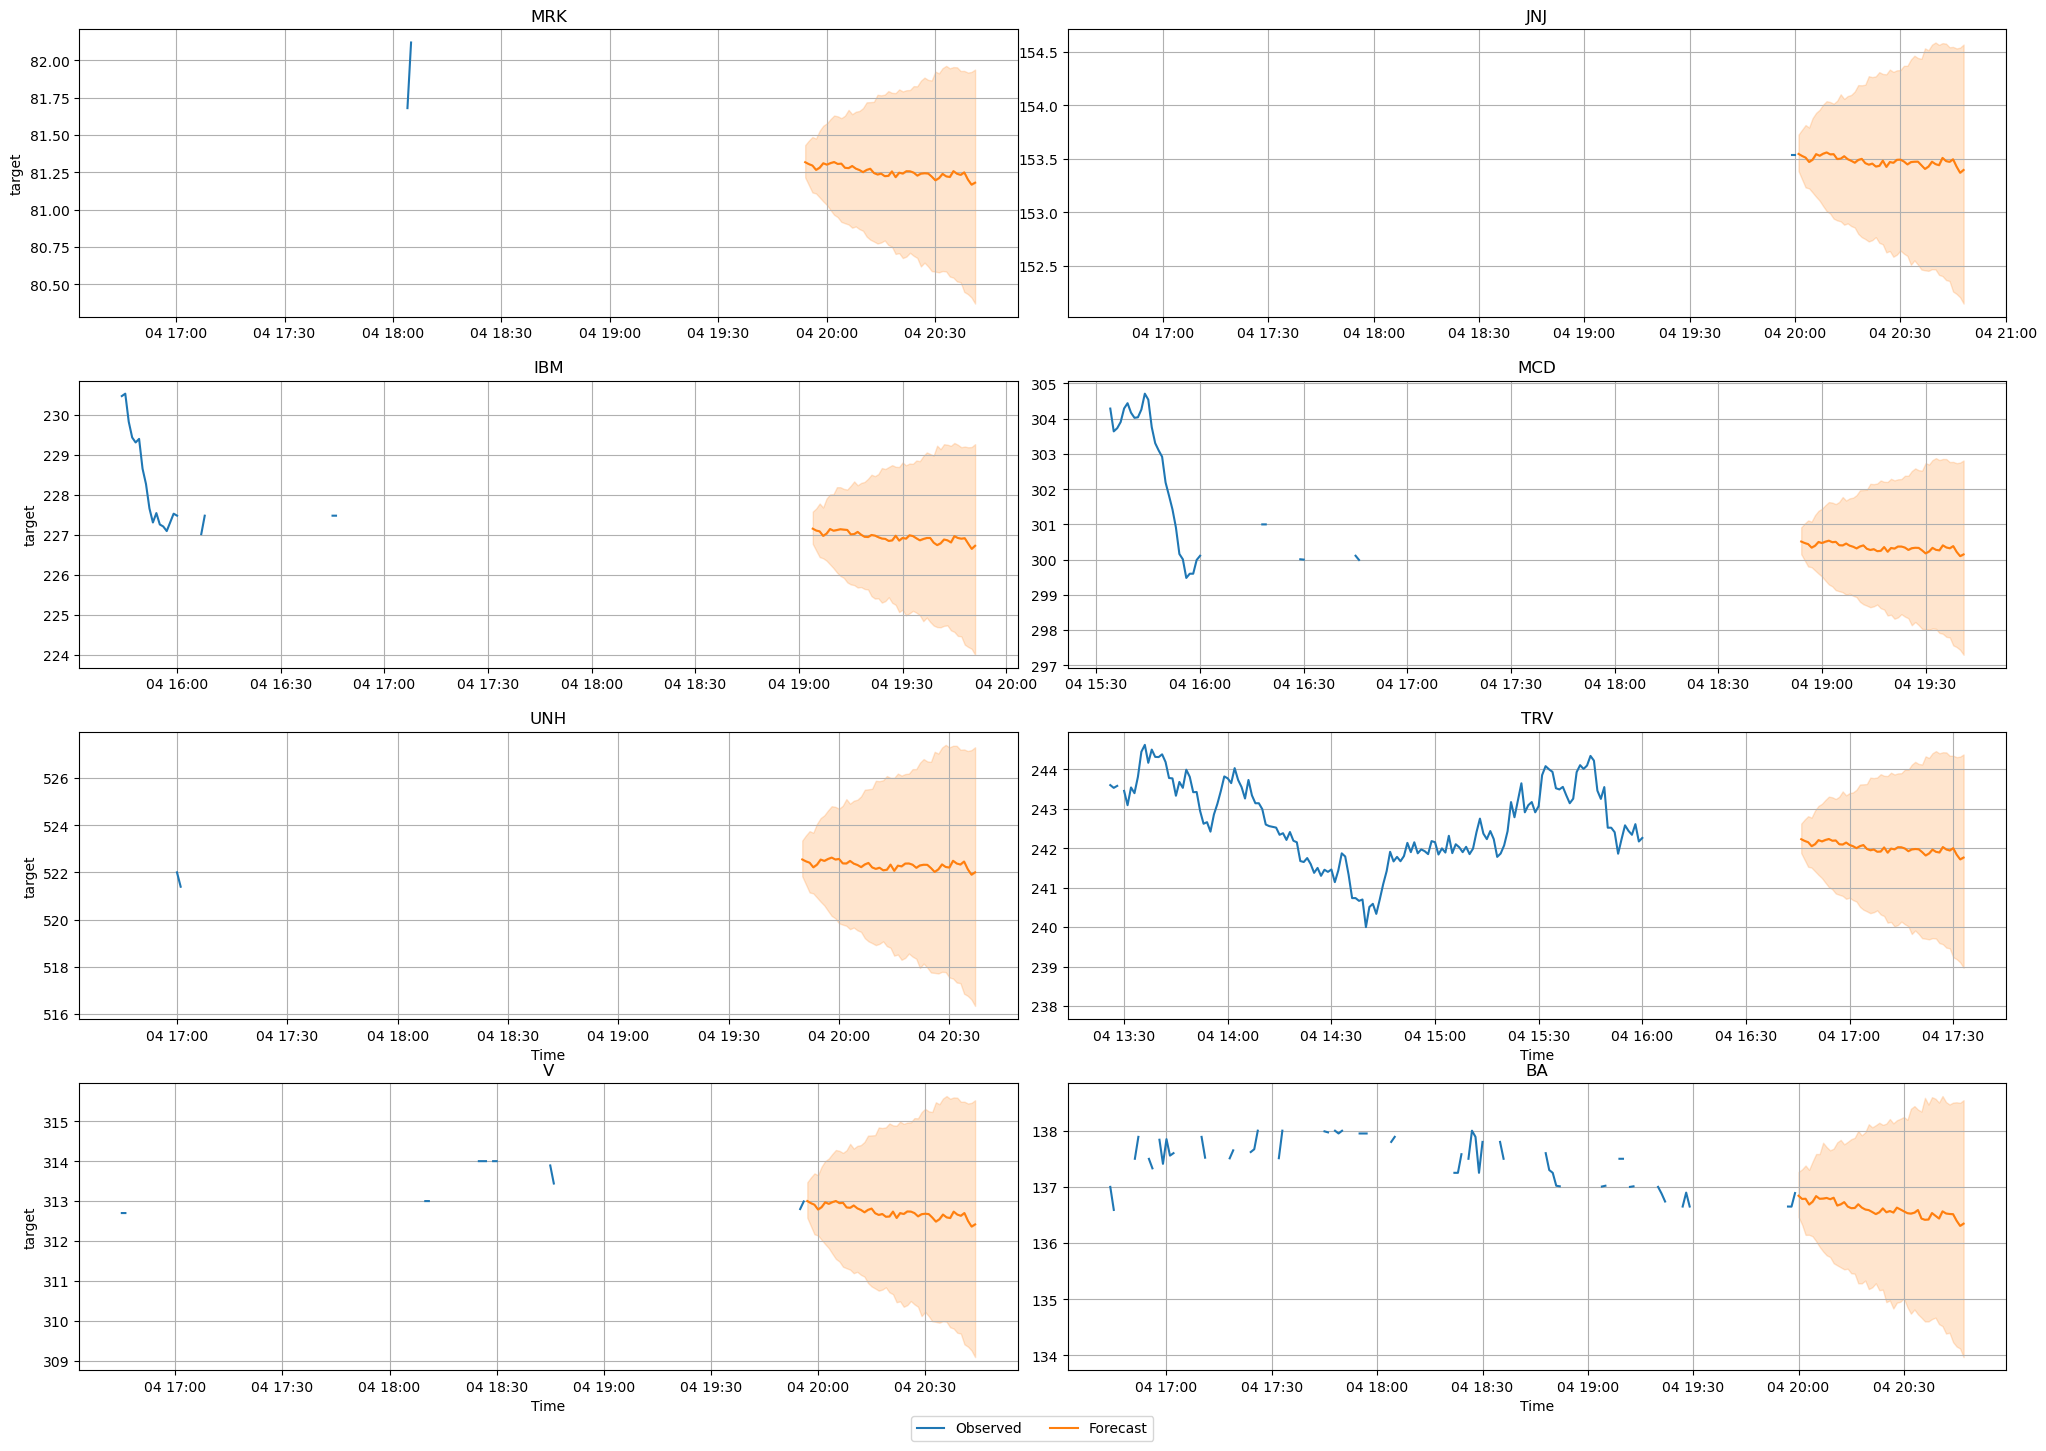

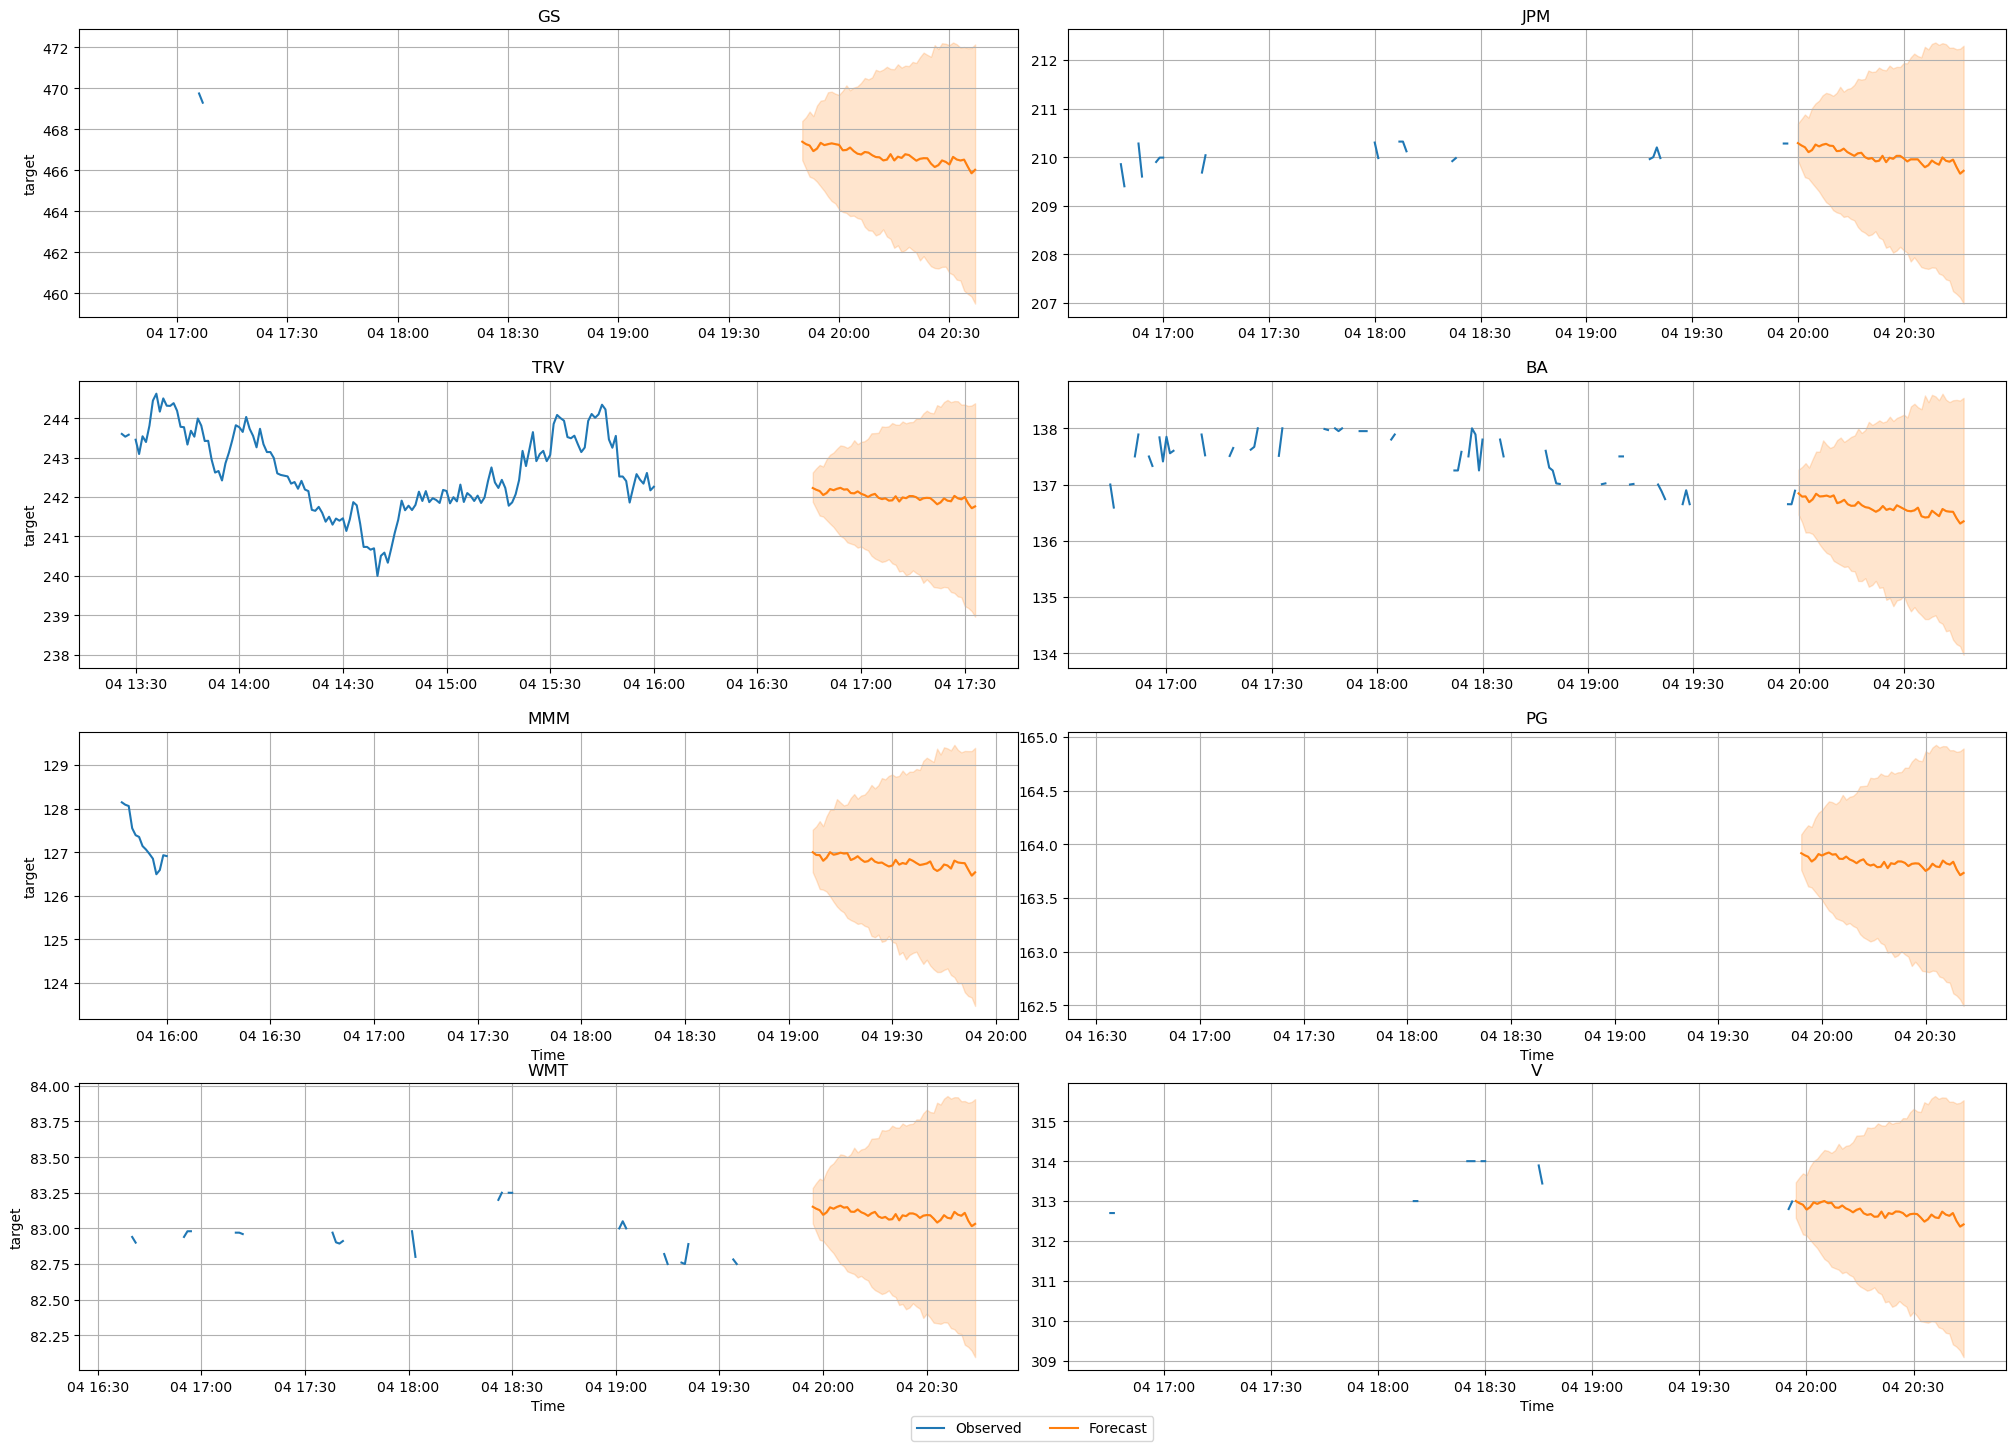

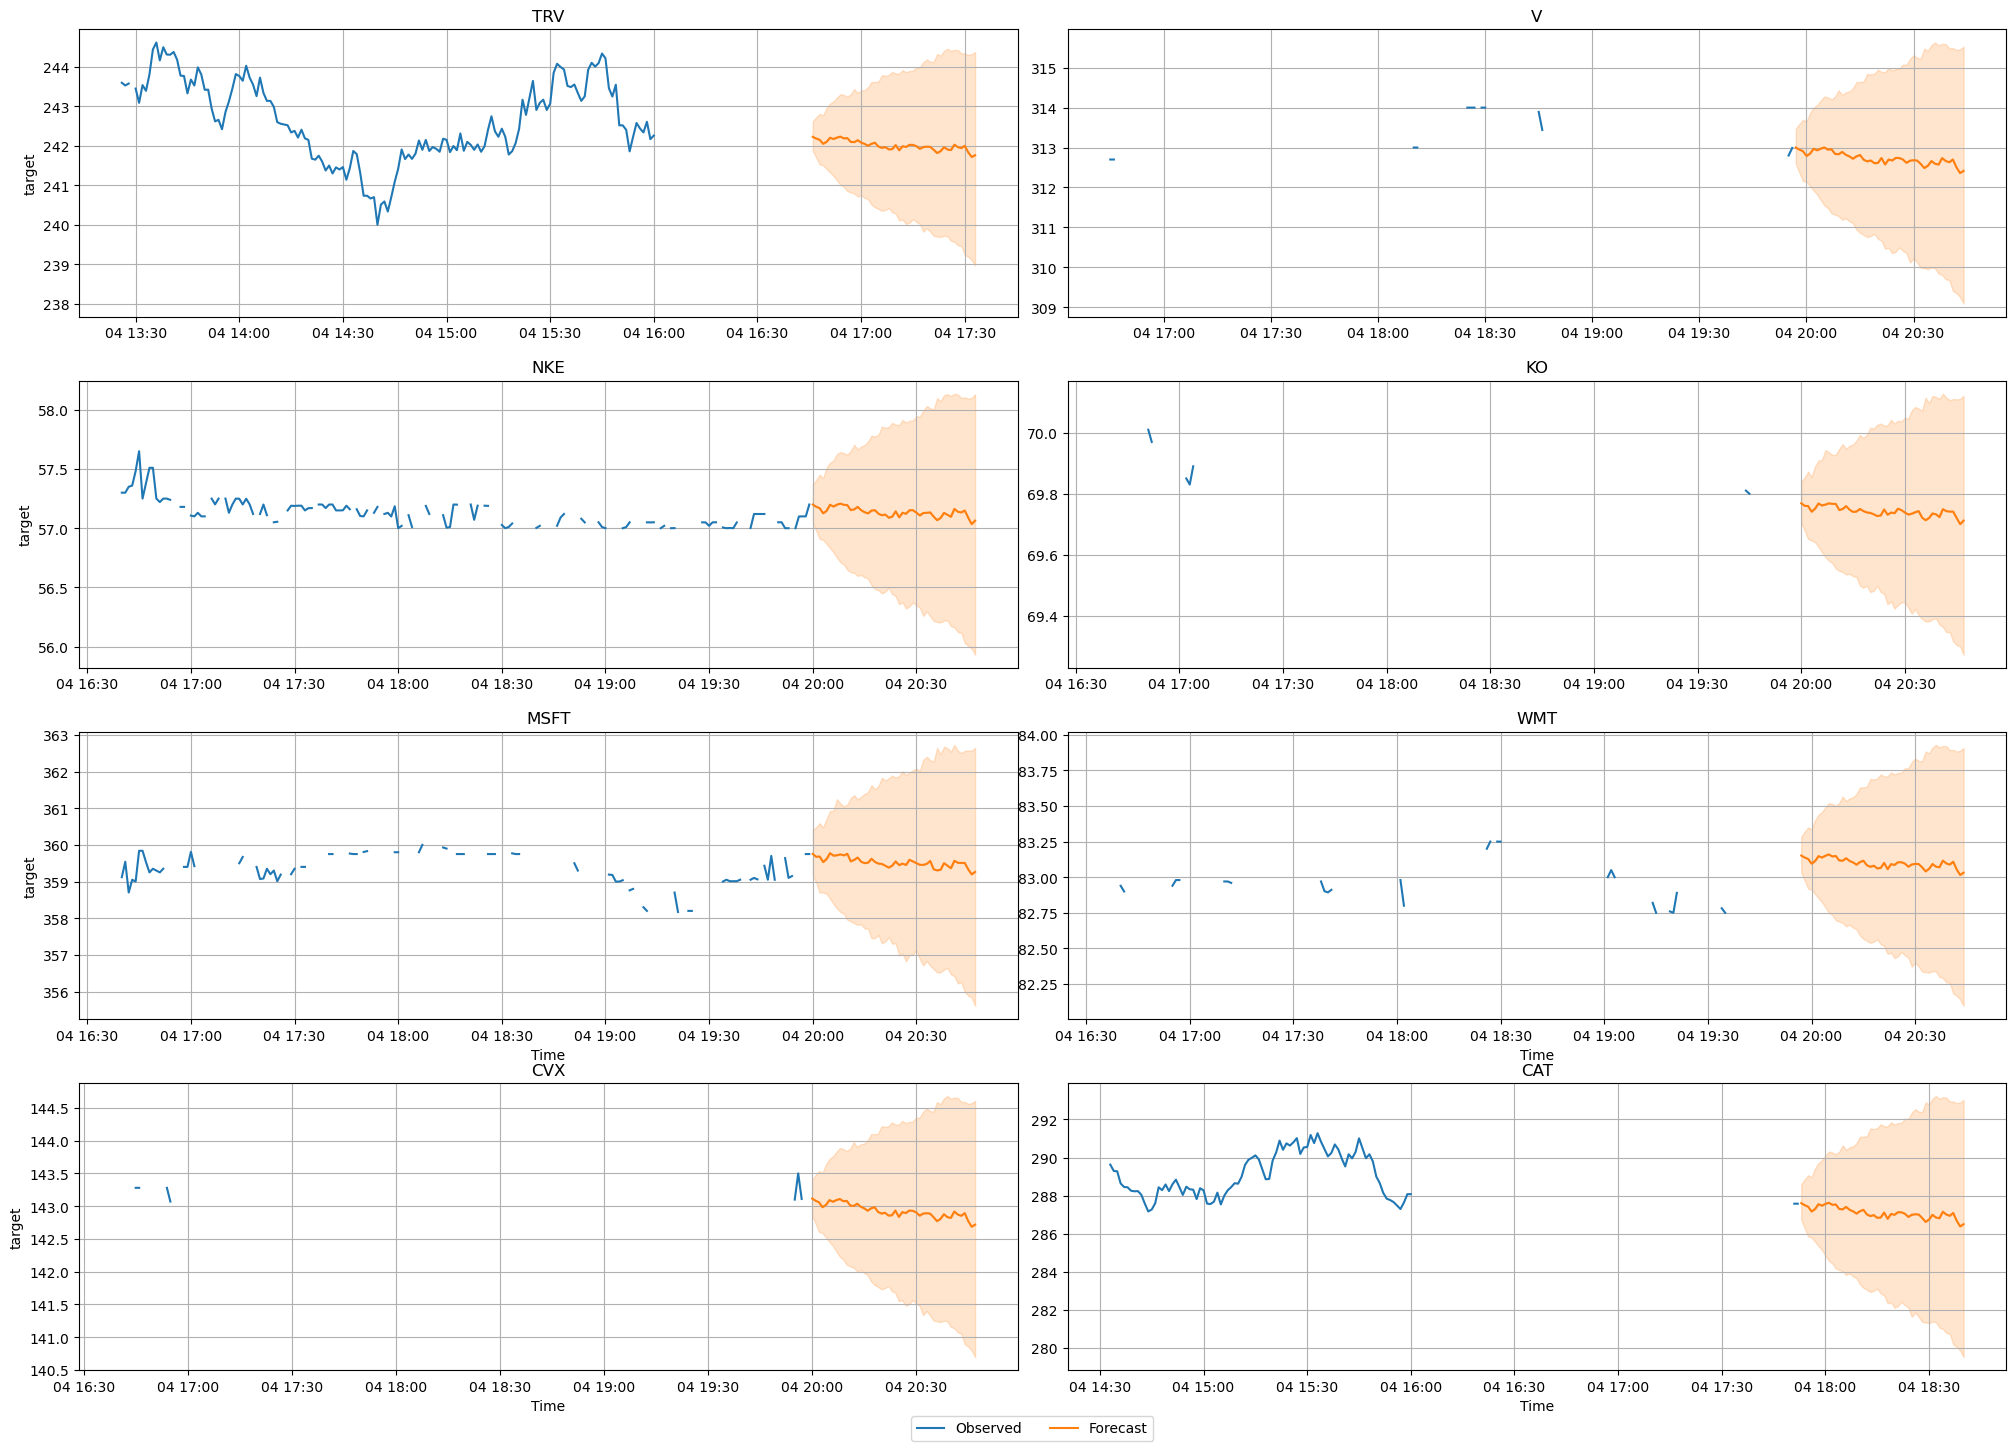

In [15]:
# Plot 4 randomly chosen time series and the respective forecasts
predictor.plot(df_filtered, predictions, quantile_levels=[0.1, 0.9], max_history_length=200, max_num_item_ids=8);
plt.show()